In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

In [2]:
username = "lavender"
project_name = "new_race_performance"
metric_name = "eval/roc_auc"
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(f"{username}/{project_name}")
summary_list = []
config_list = []
name_list = []
for run in runs:
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # run.config is the input metrics.
    # We remove special values that start with _.
    conf = nested_to_record(run.config, sep="/")
    config = {k: v for k, v in conf.items() if not k.startswith("_")}
    config_list.append(config)

    # run.name is the name of the run.
    name_list.append(run.name)

import pandas as pd

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
data_df = pd.concat([name_df, config_df, summary_df], axis=1)

data_df.to_csv("data/race_eval.csv")

In [3]:
plot_df = data_df[["name", metric_name]]

In [4]:
plot_df

,name,eval/roc_auc
0,AsianIndian,0.809750
1,Chinese,0.847718
2,White,0.796209
3,OtherRace,0.813267
4,AfricanAmericanBlack,0.773658


In [5]:
plot_df["name"] = ["Indian", "Chinese", "White", "Other Race", "Black"]
plot_df["count"] = [952, 2000, 30811, 8653, 7366]
plot_df["p"] = [0.082983, 0.112500, 0.111324, 0.113371, 0.128699]
plot_df["readmission_rate"] = plot_df["p"].apply(lambda x: f"{100*x:10.2f}%")
plot_df = plot_df.sort_values(by=metric_name, ascending=False)
plot_df

/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_6650/254438677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['name'] = ['Indian', 'Chinese', 'White', 'Other Race', 'Black']
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_6650/254438677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['count'] = [952, 2000, 30811, 8653, 7366]
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_6650/254438677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

,name,eval/roc_auc,count,p,readmission_rate
1,Chinese,0.847718,2000,0.112500,11.25%
3,Other Race,0.813267,8653,0.113371,11.34%
0,Indian,0.809750,952,0.082983,8.30%
2,White,0.796209,30811,0.111324,11.13%
4,Black,0.773658,7366,0.128699,12.87%


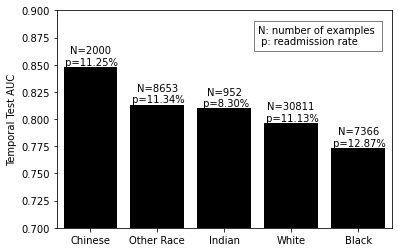

In [8]:
ax = sns.barplot(data=plot_df, x="name", y=metric_name, color="black")
# palette=sns.color_palette('Set2',5))
t = plt.text(
    0.6,
    0.85,
    "N: number of examples \n p: readmission rate",
    wrap=True,
    transform=plt.gca().transAxes,
)
t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="black"))
# Create the figure
for idx, p in enumerate(ax.patches):
    ax.annotate(
        "N="
        + str(plot_df.iloc[idx]["count"])
        + "\n p="
        + plot_df.iloc[idx]["readmission_rate"].strip(),
        (p.get_x() + 0.4, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
    )
plt.ylabel("Temporal Test AUC")
plt.xlabel("")
plt.ylim([0.7, 0.9])
plt.savefig("plots/race_analysis.png", dpi=300)